# Udacity Self Driving Car Nanodgree Term 1
# Vehicle Detection Project
**Steps: **
* HOG feature extraction 
* SVM classifier 
* Window scale choice 
* Single image process for heatmap and bounding boxes
* Video process

## Reading in training dataset

In [2]:
#list of car and notcar images 
import os 
import glob
#list all car image filenames to a text file
basedir='./data/vehicles/'
image_type =os.listdir(basedir)
cars=[]
for imtype in image_type:
    cars.extend(glob.glob(basedir + imtype + '/*'))
print('Number of Vehicle Image found:', len(cars))

with open("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')

#list all notcar image filenames to a text file
basedir='./data/non-vehicles/'
image_type =os.listdir(basedir)
notcars=[]
for imtype in image_type:
    notcars.extend(glob.glob(basedir + imtype + '/*'))
print('Number of non-Vehicle Image found:', len(notcars))

with open("notcars.txt",'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Image found: 8792
Number of non-Vehicle Image found: 8968


In [3]:
#import libraries
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

## Feature extraction functions from lessons

In [4]:
#Feature extraction functions from lessons
#extract HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
#down-sampling 64x64 color channels to 32x32
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

#computer color histogram features 
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#Define a function to extract features from a list of images
#Have this function call 3 feature extraction functions above
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
        else:
            if  vis== True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else: 
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True: 
        return np.concatenate(img_features), hog_image
    else: 
        return np.concatenate(img_features)

## Draw bouding box with sliding windows

In [5]:
#Slide window    
#Define a function that takes an image,
#start and stop positions in both x and y, 
#window size (x and y dimensions),  
#and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [7]:
#function to plot multiple images 
def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        if (len(img.shape)<3):
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Example of car / not car HOG features

C:\Users\yinli\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


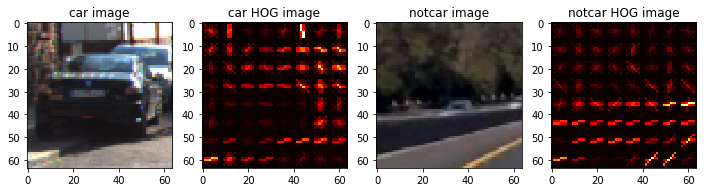

In [8]:
#show sample car/not car HOG image
#choose a randome car/notcar
car_ind = np.random.randint(0,len(cars))
notcar_ind =np.random.randint(0,len(notcars))

car_image=mpimg.imread(cars[car_ind])
notcar_image =mpimg.imread(notcars[notcar_ind])

#define feature parameters
color_space ='RGB' #can be RGB,HSV,LUV,HLS,YUV,YCrCb
orient =6
pix_per_cell =8
cell_per_block =2
hog_channel =0 #can be 0,1,2,,'ALL'
spatial_size = (16,16) 
hist_bins = 16
spatial_feat =True
hist_feat =True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space,spatial_size=spatial_size,\
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,\
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space,spatial_size=spatial_size,\
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,\
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig =plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)


## Linear SVM classifier

In [9]:
#classifier
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) #(32, 32) # Spatial binning dimensions
hist_bins = 16 #32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
n_samples =10000
random_idxs=np.random.randint(0,len(cars),n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute feature...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

C:\Users\yinli\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


145.53334665298462 Seconds to compute feature...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
21.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9968


## Example of sliding window and bounding boxes

C:\Users\yinli\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


1.0673959255218506 Seconds to process one image searching 100 windows
0.7978577613830566 Seconds to process one image searching 100 windows
0.7981691360473633 Seconds to process one image searching 100 windows
0.9190158843994141 Seconds to process one image searching 100 windows
0.8352670669555664 Seconds to process one image searching 100 windows
0.7941732406616211 Seconds to process one image searching 100 windows


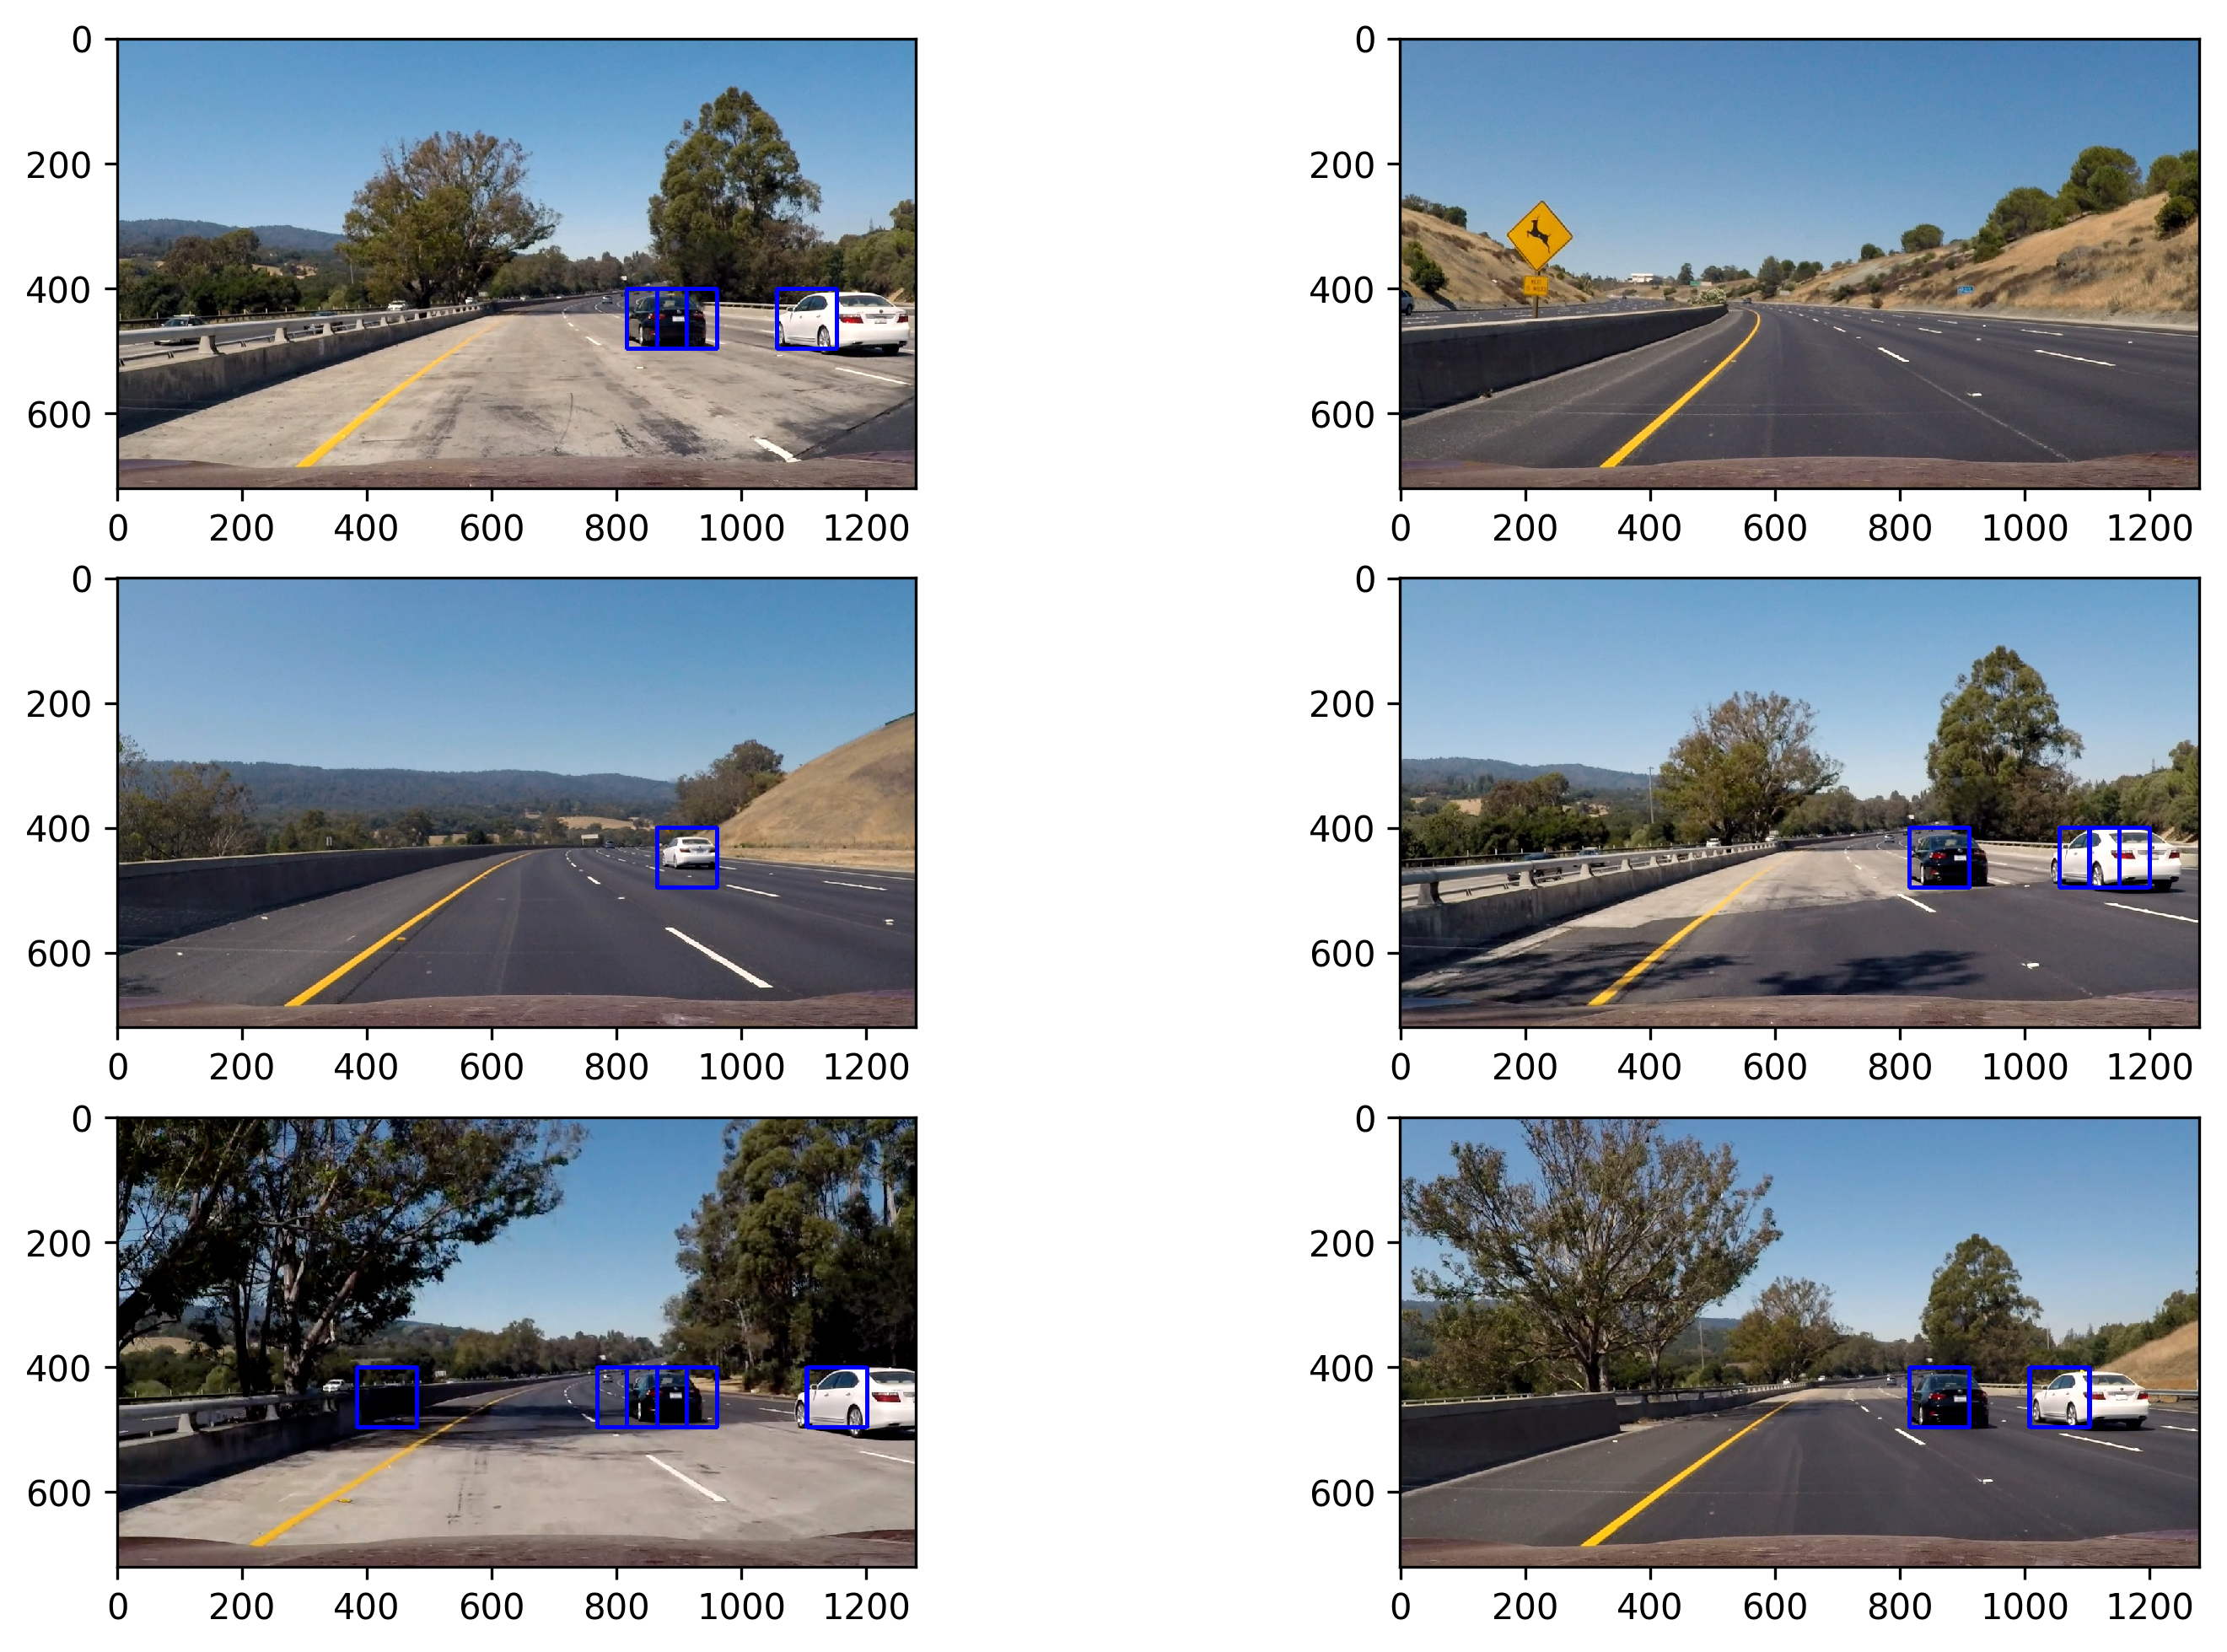

In [10]:
searchpath='./test_images/test*.jpg'
example_images = glob.glob(searchpath)
images=[]
titles=[]
y_start_stop =[400, 656]
overlap=0.5
for img_src in example_images:
    t1=time.time()
    img = mpimg.imread(img_src)
    draw_image = np.copy(img)
    #data from .png images (scaled 0 to 1 by mpimg) and the
    #image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255
    #print(np.min(img),np.max(img))
    #window size 64 too small missed large cars, 128 missed small cars and more false positive
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                         xy_window=(96,96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'Seconds to process one image searching',len(windows),'windows')

fig =plt.figure(figsize =(12,8),dpi=300)
visualize(fig,3,2,images,titles)

## HOG once for entire ROI, and sub-sampling for each window 

In [11]:
#explicit cvt colors
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, heat_map):    
    labels = label(heat_map)
    # Iterate through all detected cars
#     print('LABELS:', labels[1])
    for car_number in range(1, labels[1]+1):
#         print('car_number:',car_number)
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        
#         print(np.min(nonzerox),np.max(nonzerox))
#         print('np.max(nonzerox) - np.min(nonzerox):',np.max(nonzerox) - np.min(nonzerox))
        if (np.max(nonzerox) - np.min(nonzerox)) >65:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 10)
    # Return the image
    return img

In [21]:
#HOG once for entire ROI, and sub-sampling for each window 
out_images=[]
out_maps=[]
out_titles=[]
out_boxes=[]
#ROI
ystart = 400
ystop = 656
scale = 2

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16 #32    # Number of histogram bins

#test_images 
searchpath='./test_images/test*.jpg'
example_images = glob.glob(searchpath)
print(example_images)
for img_src in example_images:
    img_boxes=[]
    t=time.time()
    count=0
    img=mpimg.imread(img_src)
    draw_img=np.copy(img)
    #make heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255

   
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step 2->75% because windows 8x8
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] +=1
    
    heatmap= apply_threshold(heatmap, threshold=1)
    draw_img = draw_labeled_bboxes(np.copy(img), heatmap)
                
    print(time.time()-t, 'Seconds to run, total windows =', count)
    out_images.append(draw_img)    
    out_titles.append(img_src[-9:])
    
    out_images.append(heatmap)
    out_titles.append(img_src[-9:])
    
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

['./test_images\\test1.jpg', './test_images\\test2.jpg', './test_images\\test3.jpg', './test_images\\test4.jpg', './test_images\\test5.jpg', './test_images\\test6.jpg']


C:\Users\yinli\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


0.3284299373626709 Seconds to run, total windows = 185
0.32695484161376953 Seconds to run, total windows = 185
0.33196163177490234 Seconds to run, total windows = 185
0.48231983184814453 Seconds to run, total windows = 185
0.33998703956604004 Seconds to run, total windows = 185
0.33992958068847656 Seconds to run, total windows = 185


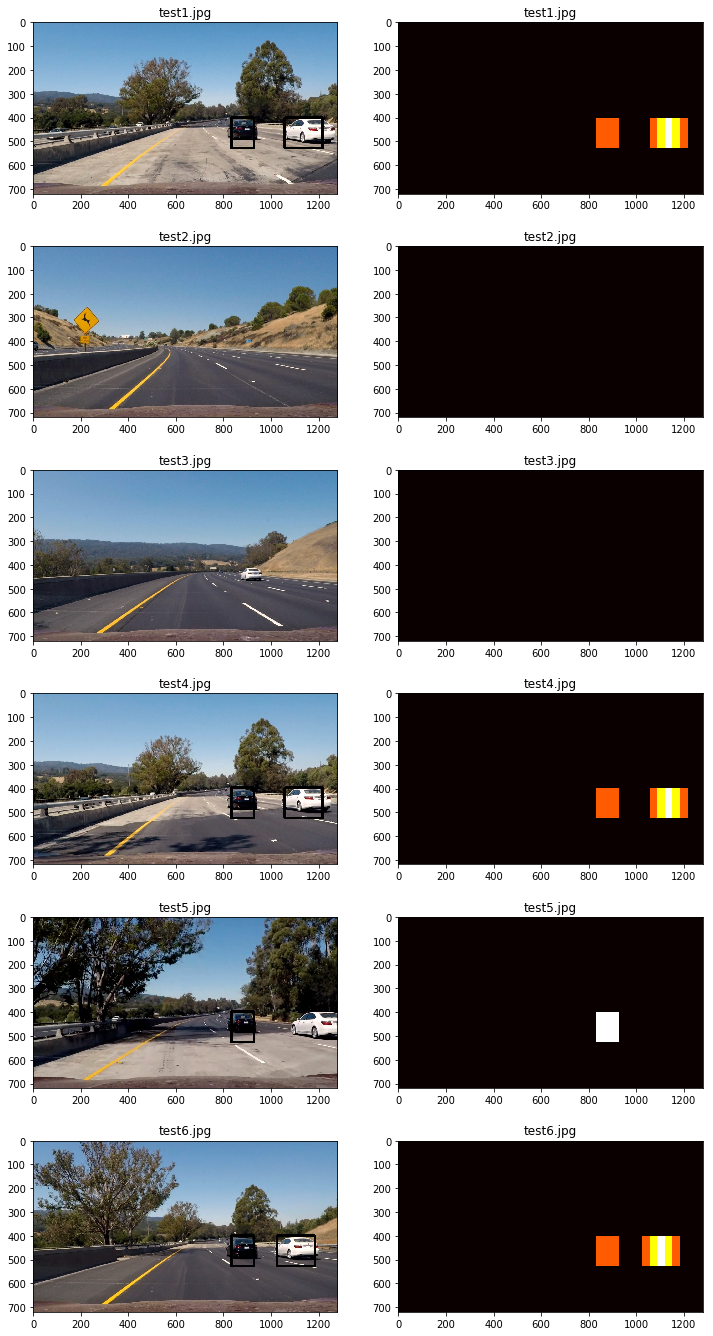

In [22]:
fig =plt.figure(figsize=(12,24))
visualize(fig,len(example_images),2,out_images,out_titles)

## Key function to find cars using hog sub-sampling and generate heatmap

In [24]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=400, ystop=720,xstart=200, xstop =1280, cells_per_step=4, scale=1):

    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (16,16) #(32, 32) # Spatial binning dimensions
    hist_bins = 16 #32    # Number of histogram bins
    
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
#     img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = img[ystart:ystop,xstart:xstop,:]#exclude cars from opposite direction
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 

                
            if test_prediction == 1:
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(255,0,0),12) 
                img_boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left+xstart:xbox_left+win_draw+xstart] +=1
                
    return draw_img, heatmap

## Experiment of window scale

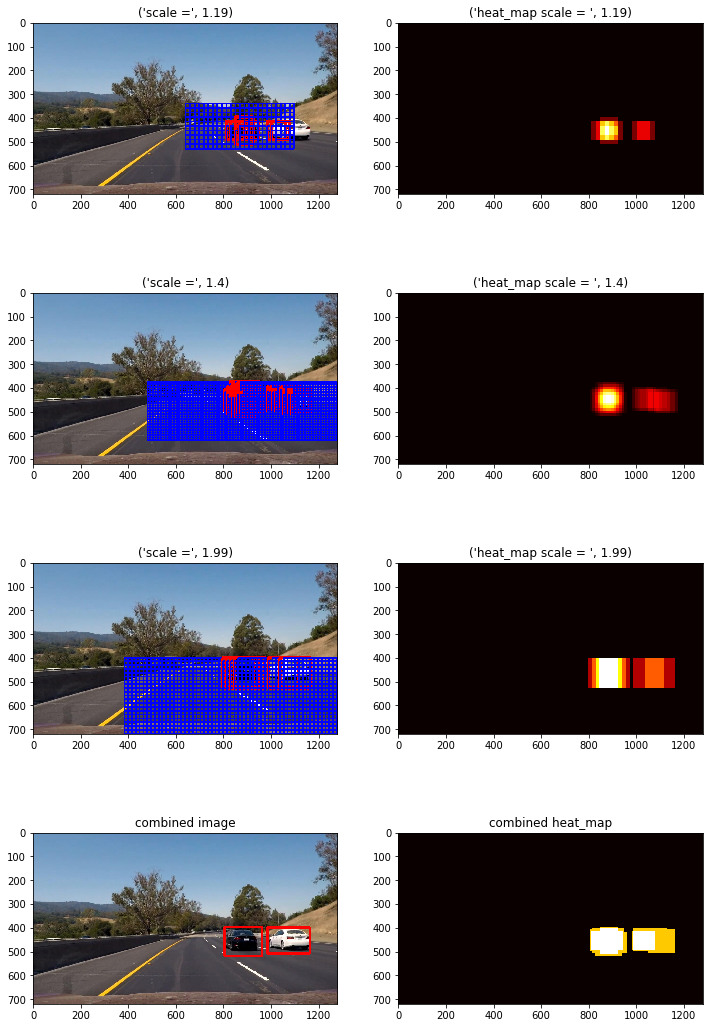

In [51]:
out_images=[]
out_titles =[]

scales =  [1.19, 1.4, 1.99]
cells_per_steps = [2,1,1]
ystarts = [340,375,400]
ystops =[532,631, 720]
xstarts =[640,480,384]
xstops =[1100,1280,1280]
# searchpath='./test_images/test5.jpg'
searchpath='./data/temp6/OrigFrame379.jpg'
example_images = glob.glob(searchpath)

for img_src in example_images:  
    img= mpimg.imread(img_src) 
    heatmap_combined = np.zeros_like(img[:,:,0])
    
    for iii in range(len(scales)):
        win_scale = scales[iii]
        cells_per_step = cells_per_steps[iii]
        ystart =ystarts[iii]
        ystop =ystops[iii]
        xstart =xstarts[iii]
        xstop =xstops[iii]
        out_img,heat_map = find_cars(img, ystart=ystart, ystop=ystop, xstart=xstart, xstop=xstop,cells_per_step=cells_per_step, scale=win_scale)
        heatmap_combined[heat_map.nonzero()]+=1
        out_images.append(out_img)
        out_images.append(heat_map)
        out_titles.append(('scale =', win_scale))
        out_titles.append(('heat_map scale = ', win_scale))
    heatmap_combined= apply_threshold(heatmap_combined, threshold=1)
    draw_img = draw_labeled_bboxes(np.copy(img), heatmap_combined)
    
    out_images.append(draw_img)
    out_images.append(heatmap_combined)
    out_titles.append('combined image')
    out_titles.append('combined heat_map')
    
fig =plt.figure(figsize=(12,24))
visualize(fig,5,2,out_images,out_titles)

## Define class for detected vehicle characteristics

In [95]:
# Define a class to average heat map across frames
class Vehicle():
    def __init__(self):
        self.detected = False #was the vehicle detected in the last iteration 
        self.n_detections = 0 #number of times this vehicle has been detected 
        self.xpixels =None #pixel x of last detection 
        self.ypixels =None #pixel y of last detection 
        self.recent_xfitted =[] #x position of last n fits of bounding box
        self.recent_numxpixels =[] # number of X pixels in last n dectections
        self.bestx = None #average x in the last n fits 
        self.recent_yfitted =[] #y position of last n fits of bounding box
        self.besty = None #average y in the last n fits 
        self.recent_wfitted =[] #width of last n fits of bounding box
        self.bestw = None #average width in the last n fits 
        self.recent_hfitted =[] #height of last n fits of bounding box
        self.besth = None #average height in the last n fits 
        self.bestleft = None
        self.bestright = None
        self.besttop = None
        self.bestbot = None
        self.bbox=[]

In [96]:
def draw_labeled_bboxes_heatmap(img, heat_map,threashold_dectection):
    n=10 #average of n frames
    labels = label(heat_map)

    global carslist
    
#     print('labels:',labels[1],'len(carslist):', len(carslist))
    if labels[1] <len(carslist):
#         print('reset carslist')
        carslist =[]
    for car_number in range(1, labels[1]+1):  
             
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if (np.max(nonzerox) - np.min(nonzerox))<65:
            pass
#             print ("too narrow")
        else:
            car = Vehicle()

            for caridx in carslist:
    #             print('outif')
                if ((np.min(nonzerox) >= caridx.bestright or np.max(nonzerox) <= caridx.bestleft) == True): #new car
    #                 print('n_dtection -1:',caridx.n_detections)
#                     caridx.n_detections -=1
                    pass
                elif((np.max(nonzerox) - np.min(nonzerox))  <= (caridx.bestright-caridx.bestleft)//2+10) :#one box to seperate
#                     print('need to seperate')
            
                    caridx.n_detections =1
#                     print("caridx.n_detections:",caridx.n_detections)
                    caridx.xpixels = nonzerox #pixel x of last detection 
                    caridx.ypixels = nonzeroy #pixel y of last detection 

                    caridx.recent_numxpixels = len(caridx.xpixels)
                    caridx.recent_xfitted = caridx.xpixels
                    caridx.recent_yfitted = caridx.ypixels
                    caridx.recent_wfitted = (np.max(caridx.recent_xfitted)-np.min(caridx.recent_xfitted))
                    caridx.recent_hfitted = (np.max(caridx.recent_yfitted)-np.min(caridx.recent_yfitted))
                    caridx.bestx =  np.average(caridx.recent_xfitted)
                    caridx.besty =  np.average(caridx.recent_yfitted)
                    caridx.bestw =  np.average(caridx.recent_wfitted)
                    caridx.besth =  np.average(caridx.recent_hfitted)

                    caridx.bestleft = (int)(caridx.bestx - np.ceil(caridx.bestw/2))
                    caridx.bestright = (int)(caridx.bestx + np.ceil(caridx.bestw/2))
                    caridx.besttop = (int)(caridx.besty - np.ceil(caridx.besth/2))
                    caridx.bestbot =(int)(caridx.besty + np.ceil(caridx.besth/2))

                    caridx.bbox = (((caridx.bestleft), (caridx.besttop)),((caridx.bestright), (caridx.bestbot)))                

                else: #not a new car 
#                     print('##Existing car####', len(carslist))
    #                 print('before +1 caridx.n_detections:', caridx.n_detections) 
                    car.detected = True
        
                    caridx.n_detections +=1
#                     print("caridx.n_detections:",caridx.n_detections)
                
                    caridx.xpixels = nonzerox #pixel x of last detection 
                    caridx.ypixels = nonzeroy #pixel y of last detection 
    #                 print('after +1 caridx.n_detections:', caridx.n_detections)   
                    if caridx.n_detections < n: 
#                     print('n_d <n')    
#                         print('caridx.recent_numxpixels:',caridx.recent_numxpixels)
                        caridx.recent_numxpixels = np.append(caridx.recent_numxpixels, len(caridx.xpixels))
                        caridx.recent_xfitted = np.append(caridx.recent_xfitted, caridx.xpixels)
                        caridx.recent_yfitted = np.append(caridx.recent_yfitted, caridx.ypixels)
                        caridx.recent_wfitted = np.append(caridx.recent_wfitted, (np.max(caridx.recent_xfitted)-np.min(caridx.recent_xfitted)))
                        caridx.recent_hfitted = np.append(caridx.recent_hfitted, (np.max(caridx.recent_yfitted)-np.min(caridx.recent_yfitted)))

                    elif caridx.n_detections >= n: #>n
    #                     caridx.n_detections -=1 
#                         print('caridx.recent_numxpixels:',caridx.recent_numxpixels)
                        caridx.recent_numxpixels = np.append(caridx.recent_numxpixels[1:], len(caridx.xpixels))
                        caridx.recent_xfitted = np.append(caridx.recent_xfitted[(caridx.recent_numxpixels[0]):], caridx.xpixels)
                        caridx.recent_yfitted = np.append(caridx.recent_yfitted[(caridx.recent_numxpixels[0]):], caridx.ypixels)
                        caridx.recent_wfitted = np.append(caridx.recent_wfitted[1:], (np.max(caridx.recent_xfitted)-np.min(caridx.recent_xfitted)))
                        caridx.recent_hfitted = np.append(caridx.recent_hfitted[1:], (np.max(caridx.recent_yfitted)-np.min(caridx.recent_yfitted)))
    #                         print('(caridx.recent_wfitted) after :', (caridx.recent_wfitted))
    #                     print('x range after:', np.min(caridx.recent_xfitted),np.max(caridx.recent_xfitted),np.average(caridx.recent_xfitted),(np.max(caridx.recent_xfitted)-np.min(caridx.recent_xfitted)))
                    caridx.bestx =  np.average(caridx.recent_xfitted)
                    caridx.besty =  np.average(caridx.recent_yfitted)
                    caridx.bestw =  np.average(caridx.recent_wfitted)
                    caridx.besth =  np.average(caridx.recent_hfitted)

                    caridx.bestleft = (int)(caridx.bestx - np.ceil(caridx.bestw/2))
                    caridx.bestright = (int)(caridx.bestx + np.ceil(caridx.bestw/2))
                    caridx.besttop = (int)(caridx.besty - np.ceil(caridx.besth/2))
                    caridx.bestbot =(int)(caridx.besty + np.ceil(caridx.besth/2))

                    caridx.bbox = (((caridx.bestleft), (caridx.besttop)),((caridx.bestright), (caridx.bestbot)))


            if car.detected == False:

#                 print('##New car####', len(carslist))

                car.detected = True 
                car.n_detections +=1
                
#                 print("car.n_detections:",car.n_detections)
                car.xpixels = nonzerox #pixel x of last detection 
                car.ypixels = nonzeroy #pixel y of last detection 

                car.recent_numxpixels = len(car.xpixels)
                car.recent_xfitted = car.xpixels  
                car.recent_yfitted = car.ypixels
                car.recent_wfitted = np.max(nonzerox) -np.min(nonzerox)
                car.recent_hfitted = np.max(nonzeroy) -np.min(nonzeroy)
                car.bestx =  np.average(car.recent_xfitted)
                car.besty =  np.average(car.recent_yfitted)
                car.bestw =  np.average(car.recent_wfitted)
                car.besth =  np.average(car.recent_hfitted)
                car.bestleft = (int)(car.bestx - np.ceil(car.bestw/2))
                car.bestright = (int)(car.bestx + np.ceil(car.bestw/2))
                car.besttop = (int)(car.besty - np.ceil(car.besth/2))
                car.bestbot =(int)(car.besty + np.ceil(car.besth/2))
    #             print(car.bestx, car.bestw)
    #             print(np.min(nonzerox),np.max(nonzerox), car.bestleft, car.bestright)
                car.bbox = (((car.bestleft), (car.besttop)),((car.bestright), (car.bestbot))) 
                carslist.append(car)


#     print('len(carslist)',len(carslist))
    for carplot in carslist: 
#         print('carplot.n_detections:',carplot.n_detections, 'carplot.n_detections:',carplot.n_detections)
        if carplot.n_detections >=threashold_dectection:# and carplot.detected==True:
            bbox =carplot.bbox
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)

    return img

## Full Pipeline for each frame 

In [97]:
#Full Pipeline for each frame 
def process_image_heatmap(img):   
    
    scales =  [1.19, 1.4, 1.99]
    cells_per_steps = [2,1,1]
    ystarts = [340,375,400]
    ystops =[532,631, 720]
    xstarts =[640,480,384]
    xstops =[1100,1280,1280]
    
    heatmap_combined = np.zeros_like(img[:,:,0])
   
    for iii in range(len(scales)):
        win_scale = scales[iii]
        cells_per_step = cells_per_steps[iii]
        ystart =ystarts[iii]
        ystop =ystops[iii]
        xstart =xstarts[iii]
        xstop =xstops[iii]
        out_img,heat_map = find_cars(img, ystart=ystart, ystop=ystop, xstart=xstart, xstop=xstop, cells_per_step=cells_per_step, scale=win_scale)
        heatmap_combined[heat_map.nonzero()]+=1
 
    heatmap_combined= apply_threshold(heatmap_combined, threshold=1)
#     draw_img = draw_labeled_bboxes(np.copy(img), heatmap_combined)
    draw_img = draw_labeled_bboxes_heatmap(np.copy(img), heatmap_combined, threashold_dectection =1)
    return draw_img

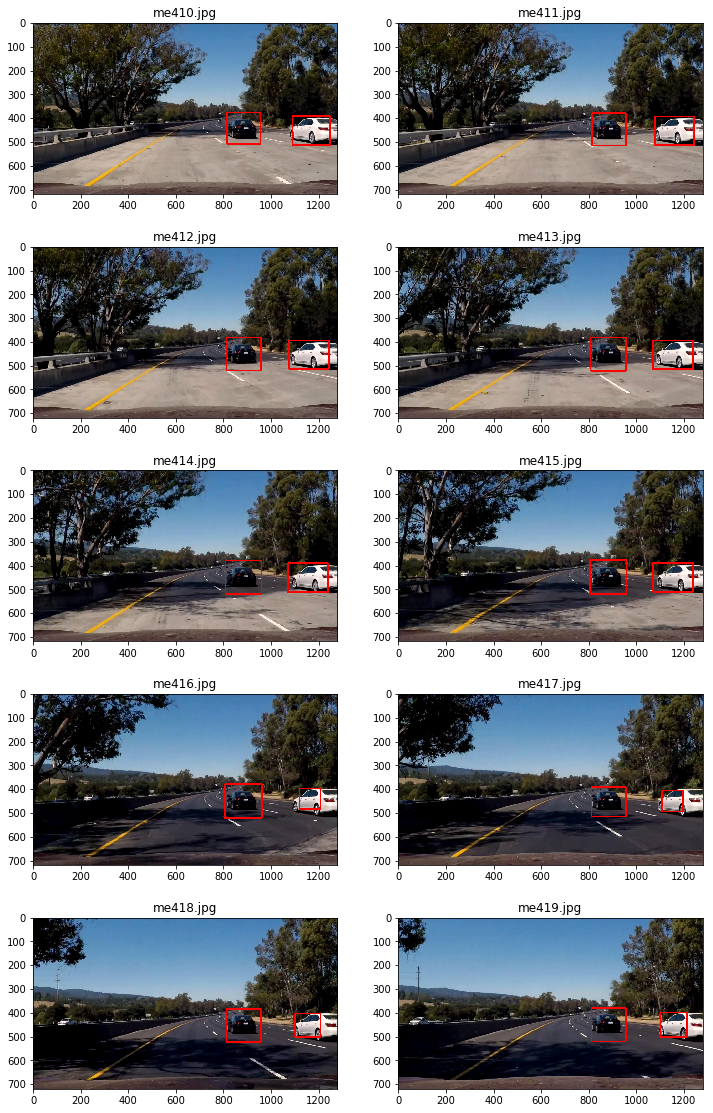

In [98]:
out_images=[]
out_titles =[]
carslist=[]
# searchpath='./test_images/test*.jpg'
searchpath='./data/temp6/OrigFrame41*.jpg'
example_images = glob.glob(searchpath)
carslist=[]
for img_src in example_images: 
#     print(img_src)
    img= mpimg.imread(img_src)
#     draw_img,heatmap_combined= process_image(img)    
    draw_img= process_image_heatmap(img)
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
#     out_images.append(heat_map)
#     out_titles.append(img_src[-9:])
    
fig =plt.figure(figsize=(12,24))
visualize(fig,len(example_images)//2+1,2,out_images,out_titles)

## Video Process

In [99]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

carslist=[]
file_name = 'lane_project_video.mp4'
video_name = "test_videos/"+file_name
output_name = 'output_videos/output_backup_withclass_'+file_name
 
# clip1 = VideoFileClip(video_name).subclip(41,43)
clip1 = VideoFileClip(video_name)
#process the images and generate the clip with lanelines
output_clip = clip1.fl_image(process_image_heatmap) 
#write the ouput clip to mp4
%time output_clip.write_videofile(output_name, audio=False)

#debug the original and processed frames from the videos
# clip1.write_images_sequence('./test_images/debug_13_15/temp5/OrigFrame%03d.jpg', progress_bar=True,fps=10)
# output_clip.write_images_sequence('./test_images/debug_13_15/temp5/ImproveFrame%03d.jpg', progress_bar=True,fps=10)

[MoviePy] >>>> Building video output_videos/output_backup_withclass_lane_project_video.mp4
[MoviePy] Writing video output_videos/output_backup_withclass_lane_project_video.mp4



  5%|████▎                                                                           | 67/1261 [02:25<43:13,  2.17s/it]


 11%|████████▍                                                                      | 135/1261 [05:00<41:46,  2.23s/it]


 16%|████████████▋                                                                  | 203/1261 [07:30<39:09,  2.22s/it]


 21%|████████████████▉                                                              | 271/1261 [10:02<36:41,  2.22s/it]


 27%|█████████████████████▏                                                         | 339/1261 [12:55<35:10,  2.29s/it]


 32%|█████████████████████████▍                                                     | 407/1261 [15:37<32:47,  2.30s/it]


 38%|█████████████████████████████▊                                                 | 475/1261 [18:14<30:10,  2.30s/it]


 43%|██████████████████████████████████                                             | 543/1261 [20:47<27:29,  2.30s/it]


 48%|██████████████████████████████████████▎                                        | 611/1261 [23:21<24:50,  2.29s/it]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [25:57<22:15,  2.29s/it]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [29:00<19:57,  2.33s/it]


 65%|███████████████████████████████████████████████████                            | 815/1261 [31:57<17:29,  2.35s/it]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [34:40<14:50,  2.36s/it]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [37:26<12:12,  2.36s/it]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [40:39<09:39,  2.39s/it]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [43:43<06:59,  2.41s/it]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [46:46<04:17,  2.43s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [49:24<01:32,  2.42s/it]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [51:05<00:02,  2.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_backup_withclass_lane_project_video.mp4 

Wall time: 51min 7s
